In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers as ppb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
import pickle

from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
def save_pickle(obj, filename):
    with open(f"{filename}.pkl", mode="wb") as f:
        pickle.dump(obj, f)

def load_pickle(filename):
    with open(f"{filename}.pkl", mode="rb") as f:
        obj = pickle.load(f)
        return obj

test_obj = [1,2,3]
test_filename="test"
try:
    save_pickle(test_obj, test_filename)
    test_load = load_pickle(test_filename)
    assert test_obj==test_load, "TEST"
except Exception as err:
    print(err)

In [3]:
! nvidia-smi

Thu Jul 13 23:43:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    22W / 170W |    919MiB / 12288MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
df = pd.read_csv(
    'STT2.tsv',
    delimiter='\t',
    header=None
).rename(columns={0:"text", 1:"target"})
df.shape

(6920, 2)

In [21]:
df.head()

,text,target
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [33]:
tmp_df=df.copy()

In [34]:
true_df=df[df.target==1]
false_df=df[df.target==0].iloc[:500]

In [36]:
df=pd.concat([true_df, false_df])

In [6]:
df.target.value_counts()

target
1    3610
0    3310
Name: count, dtype: int64

In [33]:
train_df, test_df = train_test_split(df, stratify=df.target, random_state=42, test_size=.2)

# Baseline

In [11]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

In [12]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [65]:
class BertClassifier(torch.nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.bert = bert_model
        self.l1 = torch.nn.Linear(768, n_classes)
    def forward(self, input_ids, attention_mask):
        embeddings = self.bert(input_ids, attention_mask=attention_mask)["last_hidden_state"][:,0,:]
        logits = self.l1(embeddings)
        return logits

In [66]:
model = BertClassifier().to(device)
criteria = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=1e-6)
softmax = torch.nn.Softmax(dim=1)

In [67]:
n_epochs = 10

In [85]:
for epoch in range(n_epochs):
    model.train()
    losses, labels, probas = [], [], []
    for batch in train_dataloader:
        input_ids, attention_mask, label = batch
        input_ids = input_ids.to(device)
        attention_mask=attention_mask.to(device)
        label = label[0].to(device)
        logits=model(input_ids, attention_mask=attention_mask)
        loss = criteria(logits, label)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses += [loss.item()]
        proba = softmax(logits)[:,1].tolist()
        labels += label.tolist()
        probas += proba
    
    train_roc = roc_auc_score(labels, probas)
    train_loss_mean = np.mean(losses)
    print(f"Loss: {train_loss_mean} AUC: {train_roc}")
        
    model.eval()
    with torch.no_grad():
        losses, labels, probas = [], [], []
        for batch in test_dataloader:
            input_ids, attention_mask, label = batch
            input_ids = input_ids.to(device)
            attention_mask=attention_mask.to(device)
            label = label[0].to(device)
            logits=model(input_ids, attention_mask=attention_mask)
            loss = criteria(logits, label)
            proba = softmax(logits)[:,1].tolist()
            labels += label.tolist()
            probas += proba
            losses += [loss.item()]
        test_roc = roc_auc_score(labels, probas)
        test_loss_mean = np.mean(losses)
        print(f"Loss: {test_loss_mean} AUC: {test_roc}")

Loss: 0.676143833275499 AUC: 0.6378981340644901
Loss: 0.6555134816603227 AUC: 0.7753962641537857
Loss: 0.6274776794444555 AUC: 0.7991698904101564
Loss: 0.5837294676087119 AUC: 0.853771413746642
Loss: 0.5160065461164234 AUC: 0.8744958433061905
Loss: 0.4419590871442448 AUC: 0.9042919550426392
Loss: 0.4029780201528264 AUC: 0.910547525545857
Loss: 0.370471019636501 AUC: 0.9227975328685841
Loss: 0.35186436532557697 AUC: 0.9274594948573534
Loss: 0.33917814222249115 AUC: 0.9318923600940656
Loss: 0.3190363859650732 AUC: 0.9396684426023717
Loss: 0.3212597905234857 AUC: 0.9373425613644544
Loss: 0.29686379629647597 AUC: 0.9472559648843846
Loss: 0.31130354648286646 AUC: 0.9403950925174281
Loss: 0.28076639531672687 AUC: 0.9525151214317397
Loss: 0.3062629848718643 AUC: 0.9425709886100208
Loss: 0.26454226732596586 AUC: 0.9577707473784637
Loss: 0.3014744852076877 AUC: 0.9440125197713636
Loss: 0.24972727732069191 AUC: 0.9623738660233824
Loss: 0.29785674742676993 AUC: 0.9453222418424818


In [22]:
test=df.text.iloc[0]
test

'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'

In [23]:
tokenizer.encode_plus(test, add_special_tokens=True, truncation=True)

{'input_ids': [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [24]:
tokenized_test=tokenizer(test, add_special_tokens=True)
tokenized_test

{'input_ids': [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
tokens=df.apply(lambda x: tokenizer(x.text, add_special_tokens=True), axis=1).tolist()

In [34]:
train_tokens = train_df.apply(lambda x: tokenizer(x.text, add_special_tokens=True), axis=1).tolist()
test_tokens = test_df.apply(lambda x: tokenizer(x.text, add_special_tokens=True), axis=1).tolist()

In [26]:
def get_max_len(tokens):
    key="input_ids"
    get_array=lambda x: x[key]
    max_len=0
    for value in tokens:
        cur_len=len(get_array(value))
        max_len=max(max_len, cur_len)
    return max_len

def padding(max_len, value):
    padded = value + [0]*(max_len-len(value))
    return padded

def make_padded_tokens(max_len, tokens):
    #input_ids, attention_mask = [], []
    result=[]
    for token in tokens:
        cur_id, cur_att = token["input_ids"], token["attention_mask"]
        result.append({"input_ids":padding(max_len,cur_id), "attention_mask":padding(max_len, cur_att)})
        #input_ids.append(padding(max_len, cur_id))
        #attention_mask.append(padding(max_len, cur_att))
    
    return result

In [28]:
df.target.value_counts()

target
1    3610
0    3310
Name: count, dtype: int64

In [35]:
max_len=get_max_len(tokens)

In [30]:
padded_tokens=make_padded_tokens(max_len, tokens)

In [36]:
train_padded=make_padded_tokens(max_len, train_tokens)
test_padded=make_padded_tokens(max_len, test_tokens)

In [37]:
for i in range(len(train_padded)):
    train_padded[i]["label"]=[train_df.target.iloc[i]]

for i in range(len(test_padded)):
    test_padded[i]["label"]=[test_df.target.iloc[i]]

In [31]:
for i in range(len(padded_tokens)):
    padded_tokens[i]["label"]=[df.target.iloc[i]]

In [75]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data=data
        self.len=len(data)
    def __getitem__(self, idx):
        item=self.data[idx]
        input_id, attention_mask, label = item["input_ids"], item["attention_mask"], item["label"]
        return np.array(input_id), np.array(attention_mask), label
    def __len__(self):
        return self.len
def create_dataloader(dataset, batch_size=32, shuffle=False):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [76]:
BATCH_SIZE=64

In [79]:
train_dataset=CustomDataset(train_padded)
train_dataloader=create_dataloader(train_dataset, batch_size=BATCH_SIZE)
test_dataset=CustomDataset(test_padded)
test_dataloader=create_dataloader(test_dataset, batch_size=BATCH_SIZE)

In [78]:
next(iter(train_dataloader))

[tensor([[  101,  3904,  1997,  ...,     0,     0,     0],
         [  101,  4832,  2004,  ...,     0,     0,     0],
         [  101,  1996,  4654,  ...,     0,     0,     0],
         ...,
         [  101, 25912,  2015,  ...,     0,     0,     0],
         [  101,  1996, 18987,  ...,     0,     0,     0],
         [  101,  2096,  8498,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 [tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
          1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
          1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])]]

In [45]:
dataset=CustomDataset(padded_tokens)
dataloader=create_dataloader(dataset, batch_size=BATCH_SIZE)

In [46]:
next(iter(dataloader))

[tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  4593,  2128,  ...,     0,     0,     0],
         [  101,  2027,  3653,  ...,     0,     0,     0],
         ...,
         [  101,  1037, 19240,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0],
         [  101,  1996,  6919,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 [tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
          0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
          1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])]]

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
model=model.to(device)

In [22]:
#Embeddings
embeddings = []
model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, label = batch
        input_ids = input_ids.to(device)
        attention_mask=attention_mask.to(device)
        outputs=model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs)

In [23]:
prepared_embeddings=[]
for emb in embeddings:
    for x in emb["last_hidden_state"][:,0,:]:
        prepared_embeddings.append(x.cpu().numpy())

In [24]:
len(prepared_embeddings[0])

768

In [25]:
y=df.target.values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(prepared_embeddings, y, stratify=y)

In [239]:
try:
    save_pickle({"embeddings":X_train, "labels":y_train}, "train_data")
    save_pickle({"embeddings":X_test, "labels":y_test}, "test_data")
except Exception as err:
    print(err)

In [27]:
lr=LogisticRegression().fit(X_train, y_train)
y_pred=lr.predict(X_test)
y_proba=lr.predict_proba(X_test)[:,1]

In [28]:
roc_auc_score(y_test, y_proba)

0.9153156699551186

In [29]:
accuracy_score(y_test, y_pred)

0.8317919075144509

In [30]:
confusion_matrix(y_test, y_pred)

array([[709, 119],
       [172, 730]])

In [31]:
y_train_proba=lr.predict_proba(X_train)[:,1]

In [32]:
np.mean(y_test)

0.5213872832369942

# Optuna 

## Model Class

In [26]:
class Classifier(torch.nn.Module):
    def __init__(self, n_epochs=10, 
                 lr=1e-5, dropout=.1, hidden_size=384, 
                 n_classes=2, device="cpu", weight_decay=.01):
        super().__init__()
        self.l1 = torch.nn.Linear(768, n_classes)
        self.silu = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.opt = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.criteria = torch.nn.CrossEntropyLoss()
        self.epochs = n_epochs
        self.to(device)
    def forward(self, embeddings):
        outputs=self.l1(embeddings)
        return outputs
    
    def train_step(self, train):
        for batch in train:
            X, y = batch
            X = X.to(self.device)
            y = y.to(self.device)
            preds = self(X)
            loss=self.criteria(preds, y)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
    
    def fit(self, train):
        self.train()
        for epoch in range(self.epochs):
            self.train_step(train)
    
    def predict(self, test):
        self.eval()
        with torch.no_grad():
            probas, labels = [], []
            softmax = torch.nn.Softmax(dim=-1)
            for X in test:
                X = torch.FloatTensor(X).to(self.device)
                score = self(X)
                proba = softmax(score)[1].item()
                probas.append(proba)
                label = torch.argmax(score).item()
                labels.append(label)
        return probas

In [221]:
nn = Classifier(lr=.007, n_epochs=23, dropout=.42, hidden_size=512, device=device)

## Dataloaders

In [19]:
class ClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    def __len__(self):
        return len(self.embeddings)

def create_dataloader(embeddings, labels, batch_size=1):
    dataset = ClassifierDataset(embeddings, labels)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [6]:
try:
    train_data = load_pickle("train_data")
    test_data = load_pickle("test_data")
    X_train, y_train = train_data["embeddings"], train_data["labels"]
    X_test, y_test = test_data["embeddings"], test_data["labels"]
except Exception as err:
    print(err)

In [22]:
train = create_dataloader(X_train, y_train, batch_size=64)

In [222]:
nn.fit(train)

In [223]:
pred_p=nn.predict(X_test)
roc_auc_score(y_test, pred_p)

0.8691247040928908

In [113]:
def custom_softmax(array):
    return np.exp(array)/np.sum(np.exp(array))

In [167]:
custom_softmax([-0.1375,  0.0502])

array([0.45321229, 0.54678771])

In [27]:
"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.

In this example, we optimize the validation accuracy of fashion product recognition using
PyTorch and FashionMNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole FashionMNIST dataset,
we here use a small subset of it.

"""

import os

import optuna
from optuna.trial import TrialState


def objective(trial):
    # Generate the model.
    device="cpu"

    # Generate the optimizers.
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    params={"lr" : trial.suggest_float("lr", 1e-5, 1e-1, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-4, 1e-1), 
            "n_epochs" : trial.suggest_int("n_epochs", 5, 100),
            "dropout" : trial.suggest_float("dropout", 0., .5),
            "device" : device
           }
    
    model = Classifier(**params)
    model.fit(train)
    probas = model.predict(X_test)
    
    #accuracy = accuracy_score(y_test, probas)
    roc_score = roc_auc_score(y_test, probas)
    
    return roc_score

In [28]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-07-12 23:13:50,837] A new study created in memory with name: no-name-47f53a5e-d9a6-4fe8-a017-4801ef36a82d
[I 2023-07-12 23:13:55,472] Trial 0 finished with value: 0.8904072538749102 and parameters: {'lr': 5.0383177410649175e-05, 'weight_decay': 0.0815780295946829, 'n_epochs': 93, 'dropout': 0.2624739519884348}. Best is trial 0 with value: 0.8904072538749102.
[I 2023-07-12 23:13:59,298] Trial 1 finished with value: 0.8935484216502243 and parameters: {'lr': 3.317070580173314e-05, 'weight_decay': 0.01242621179280471, 'n_epochs': 75, 'dropout': 0.38554891355959986}. Best is trial 1 with value: 0.8935484216502243.
[I 2023-07-12 23:14:02,943] Trial 2 finished with value: 0.899114420986107 and parameters: {'lr': 0.00019790694790247304, 'weight_decay': 0.037528477031941024, 'n_epochs': 72, 'dropout': 0.4956601045867328}. Best is trial 2 with value: 0.899114420986107.
[I 2023-07-12 23:14:05,033] Trial 3 finished with value: 0.9112251893269921 and parameters: {'lr': 0.005816689982039197,

[I 2023-07-12 23:15:03,232] Trial 32 finished with value: 0.9145243527534089 and parameters: {'lr': 0.008515282926860235, 'weight_decay': 0.00010792942109859977, 'n_epochs': 36, 'dropout': 0.19536904764966956}. Best is trial 13 with value: 0.916677378236233.
[I 2023-07-12 23:15:04,623] Trial 33 finished with value: 0.9073529569287788 and parameters: {'lr': 0.013980057870643157, 'weight_decay': 0.010191360386568636, 'n_epochs': 26, 'dropout': 0.10123275454235382}. Best is trial 13 with value: 0.916677378236233.
[I 2023-07-12 23:15:06,373] Trial 34 finished with value: 0.907689032423921 and parameters: {'lr': 0.005607740516452008, 'weight_decay': 0.014591494532498063, 'n_epochs': 36, 'dropout': 0.038805125155348535}. Best is trial 13 with value: 0.916677378236233.
[I 2023-07-12 23:15:07,262] Trial 35 finished with value: 0.9027027967908139 and parameters: {'lr': 0.04220150312875193, 'weight_decay': 0.006929862847729482, 'n_epochs': 17, 'dropout': 0.09131042403619834}. Best is trial 13 wi

[I 2023-07-12 23:15:59,059] Trial 64 finished with value: 0.90833440449029 and parameters: {'lr': 0.0066721638566386385, 'weight_decay': 0.012337908956905909, 'n_epochs': 45, 'dropout': 0.024772471530997445}. Best is trial 52 with value: 0.9167670876313506.
[I 2023-07-12 23:16:01,635] Trial 65 finished with value: 0.9109051811861992 and parameters: {'lr': 0.018320751516600703, 'weight_decay': 0.004411024194002242, 'n_epochs': 54, 'dropout': 0.08383365541693372}. Best is trial 52 with value: 0.9167670876313506.
[I 2023-07-12 23:16:05,281] Trial 66 finished with value: 0.9113229323992844 and parameters: {'lr': 0.0049827128307161905, 'weight_decay': 0.008164466430245276, 'n_epochs': 78, 'dropout': 0.17014774451589704}. Best is trial 52 with value: 0.9167670876313506.
[I 2023-07-12 23:16:06,678] Trial 67 finished with value: 0.9074814957635742 and parameters: {'lr': 0.02762519087078479, 'weight_decay': 0.0049494684418773405, 'n_epochs': 28, 'dropout': 0.05745076540137328}. Best is trial 52

[I 2023-07-12 23:17:00,962] Trial 96 finished with value: 0.9112747303362362 and parameters: {'lr': 0.0018657608914495437, 'weight_decay': 0.006937806125021578, 'n_epochs': 16, 'dropout': 0.11484801329165692}. Best is trial 77 with value: 0.9173240892487977.
[I 2023-07-12 23:17:01,987] Trial 97 finished with value: 0.9093814604153946 and parameters: {'lr': 0.002193392591200945, 'weight_decay': 0.010367315422933027, 'n_epochs': 20, 'dropout': 0.1411174078521089}. Best is trial 77 with value: 0.9173240892487977.
[I 2023-07-12 23:17:03,215] Trial 98 finished with value: 0.9144895401523185 and parameters: {'lr': 0.001481262107621061, 'weight_decay': 0.002953429201583317, 'n_epochs': 24, 'dropout': 0.12696120062609284}. Best is trial 77 with value: 0.9173240892487977.
[I 2023-07-12 23:17:04,599] Trial 99 finished with value: 0.9078791627837227 and parameters: {'lr': 0.0026991200708484176, 'weight_decay': 0.013839879025056906, 'n_epochs': 27, 'dropout': 0.18221238358729078}. Best is trial 77

[I 2023-07-12 23:17:44,817] Trial 128 finished with value: 0.9094711698105125 and parameters: {'lr': 0.007343092658266744, 'weight_decay': 0.00975198621367538, 'n_epochs': 46, 'dropout': 0.08436125071587525}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:17:46,654] Trial 129 finished with value: 0.9128988720717248 and parameters: {'lr': 0.0038386434426239376, 'weight_decay': 0.005938273466619745, 'n_epochs': 38, 'dropout': 0.10086961305439418}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:17:48,669] Trial 130 finished with value: 0.914160159388155 and parameters: {'lr': 0.00264540767009861, 'weight_decay': 0.003871214501184334, 'n_epochs': 41, 'dropout': 0.04901244725344378}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:17:50,358] Trial 131 finished with value: 0.9174579838683763 and parameters: {'lr': 0.0037082775469905313, 'weight_decay': 0.0003786966654844713, 'n_epochs': 34, 'dropout': 0.11153623379354709}. Best is tr

[I 2023-07-12 23:18:45,164] Trial 160 finished with value: 0.9105624109600781 and parameters: {'lr': 0.0031166223349714563, 'weight_decay': 0.009070621685564134, 'n_epochs': 50, 'dropout': 0.09753750059036707}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:18:47,342] Trial 161 finished with value: 0.916890270681363 and parameters: {'lr': 0.0013464376719306446, 'weight_decay': 0.00012012208320110802, 'n_epochs': 44, 'dropout': 0.10902238228675876}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:18:49,471] Trial 162 finished with value: 0.9159115010122433 and parameters: {'lr': 0.0039429276178815425, 'weight_decay': 0.002167905007125993, 'n_epochs': 44, 'dropout': 0.10648650362934048}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:18:51,402] Trial 163 finished with value: 0.9136942061120217 and parameters: {'lr': 0.0015288499284059442, 'weight_decay': 0.004286888988727509, 'n_epochs': 40, 'dropout': 0.11800192481491638}. Best 

[I 2023-07-12 23:19:47,120] Trial 192 finished with value: 0.9170750452563814 and parameters: {'lr': 0.0032362531548305387, 'weight_decay': 0.0002442045357600012, 'n_epochs': 39, 'dropout': 0.10649374577020058}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:19:48,904] Trial 193 finished with value: 0.9024350075516565 and parameters: {'lr': 0.003206262507107036, 'weight_decay': 0.029196017438308304, 'n_epochs': 36, 'dropout': 0.09937966962111812}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:19:50,814] Trial 194 finished with value: 0.916846085456902 and parameters: {'lr': 0.0025158827891039446, 'weight_decay': 0.00014940062803736666, 'n_epochs': 39, 'dropout': 0.12213596189255402}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:19:52,636] Trial 195 finished with value: 0.8989818653127243 and parameters: {'lr': 0.005527945507116201, 'weight_decay': 0.04264419924203393, 'n_epochs': 37, 'dropout': 0.08386848486026591}. Best is

[I 2023-07-12 23:20:45,623] Trial 224 finished with value: 0.9156330002035199 and parameters: {'lr': 0.007181832833714409, 'weight_decay': 0.00012510889118169983, 'n_epochs': 35, 'dropout': 0.10129861689160491}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:20:47,610] Trial 225 finished with value: 0.9166385487965553 and parameters: {'lr': 0.004971566674992907, 'weight_decay': 0.00011288467923552392, 'n_epochs': 39, 'dropout': 0.08326180166100598}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:20:49,665] Trial 226 finished with value: 0.9030495838555224 and parameters: {'lr': 0.002776511294259251, 'weight_decay': 0.026608075920417404, 'n_epochs': 42, 'dropout': 0.12644469726896265}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:20:51,268] Trial 227 finished with value: 0.9002418136829589 and parameters: {'lr': 0.0033782138778491603, 'weight_decay': 0.03806889626449052, 'n_epochs': 33, 'dropout': 0.11305637558965846}. Best i

[I 2023-07-12 23:21:37,507] Trial 256 finished with value: 0.9018083807320287 and parameters: {'lr': 0.056081651846978615, 'weight_decay': 0.0001396228462661925, 'n_epochs': 36, 'dropout': 0.20595749143189862}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:21:39,149] Trial 257 finished with value: 0.9135469220304853 and parameters: {'lr': 0.008308337041285105, 'weight_decay': 0.0034670012824989586, 'n_epochs': 34, 'dropout': 0.11540744944944738}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:21:40,585] Trial 258 finished with value: 0.9174325438906563 and parameters: {'lr': 0.004185950549746827, 'weight_decay': 0.0002654959259544547, 'n_epochs': 29, 'dropout': 0.019596243353494025}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:21:42,144] Trial 259 finished with value: 0.8963682423385498 and parameters: {'lr': 0.0038143815199422207, 'weight_decay': 0.05806095542784955, 'n_epochs': 32, 'dropout': 0.03365695232296714}. Best i

[I 2023-07-12 23:22:26,311] Trial 288 finished with value: 0.900905930996069 and parameters: {'lr': 0.0038144021960765163, 'weight_decay': 0.03584508786236349, 'n_epochs': 34, 'dropout': 0.025290526718790823}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:22:26,960] Trial 289 finished with value: 0.9140811615626037 and parameters: {'lr': 0.0020326315573774723, 'weight_decay': 0.0020403865028892115, 'n_epochs': 12, 'dropout': 0.11002516153100632}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:22:28,838] Trial 290 finished with value: 0.8999566181432564 and parameters: {'lr': 0.003176501803572665, 'weight_decay': 0.038989749783411756, 'n_epochs': 38, 'dropout': 0.15374095636423224}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:22:30,613] Trial 291 finished with value: 0.8940665938279936 and parameters: {'lr': 0.0050243784073373465, 'weight_decay': 0.07219215261823177, 'n_epochs': 36, 'dropout': 0.05749968169700141}. Best is 

[I 2023-07-12 23:23:15,663] Trial 320 finished with value: 0.8775118630632948 and parameters: {'lr': 0.08347872187378952, 'weight_decay': 0.04249482820667297, 'n_epochs': 16, 'dropout': 0.05427431168198294}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:23:16,646] Trial 321 finished with value: 0.9141561425495678 and parameters: {'lr': 0.010680580594041365, 'weight_decay': 0.0021977382091832014, 'n_epochs': 19, 'dropout': 0.16883480382542676}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:23:18,238] Trial 322 finished with value: 0.9123940893559133 and parameters: {'lr': 0.0009006358907576287, 'weight_decay': 0.0055032497421734486, 'n_epochs': 32, 'dropout': 0.1282789056589913}. Best is trial 110 with value: 0.9174927964694666.
[I 2023-07-12 23:23:19,665] Trial 323 finished with value: 0.9162328480992321 and parameters: {'lr': 0.0043534016371008484, 'weight_decay': 0.001929322939806396, 'n_epochs': 28, 'dropout': 0.1180122182873041}. Best is tr

Number of finished trials: 346
Best trial:
  Value: 0.9174927964694666
  Params: 
    lr: 0.00474862162112576
    weight_decay: 0.00013474112454822288
    n_epochs: 15
    dropout: 0.09250765766039594


In [30]:
nn = Classifier(lr=.00474862162112576, weight_decay=.00013474112454822288, n_epochs=15, dropout=.42, hidden_size=512, device="cpu")

In [31]:
nn.fit(train)

In [32]:
pred_p=nn.predict(X_test)
roc_auc_score(y_test, pred_p)

0.917597234272738

<Axes: ylabel='Count'>

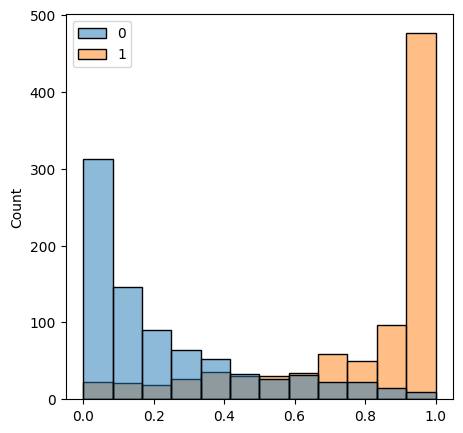

In [33]:
plt.figure(figsize=(5,5))
sns.histplot(x=pred_p, hue=y_test)

<Axes: ylabel='Count'>

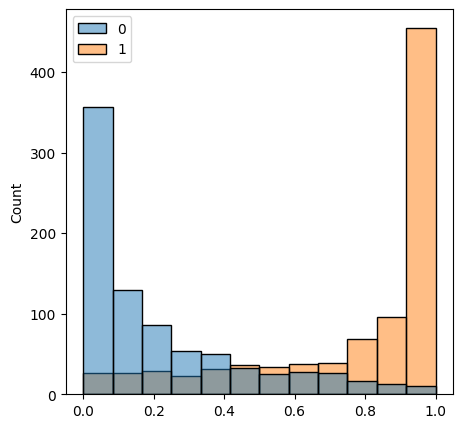

In [183]:
plt.figure(figsize=(5,5))
sns.histplot(x=y_proba, hue=y_test)

In [75]:
class CustomBertModel(torch.nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model=bert_model
        self.l1=torch.nn.Linear(768,324)
        self.l2=torch.nn.Linear(324, 1)
        self.relu=torch.nn.ReLU()
    def forward(self, input_ids, attention_mask=None):
        embeddings=self.bert_model(input_ids, attention_mask=attention_mask)
        outputs=self.l1(embeddings["last_hidden_state"][:,0,:])
        outputs=self.relu(outputs)
        outputs=self.l2(outputs)
        return outputs

In [64]:
mm=CustomBertModel(model)
mm.to(device)

CustomBertModel(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [76]:
opt=torch.optim.Adam(mm.parameters(), lr=1e-4)
criterion=torch.nn.BCELoss()

In [78]:
EPOCHS=3

In [80]:
next(iter(dataloader))

[tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  2023,  2003,  ...,     0,     0,     0],
         [  101,  5655,  6262,  ...,     0,     0,     0],
         ...,
         [  101,  2009,  2038,  ...,     0,     0,     0],
         [  101,  6320, 25624,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]]

In [88]:
losses=[]
for epoch in range(EPOCHS):
    model.train()
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        print(input_ids)
        attention_mask=attention_mask.to(device)
        labels = torch.IntTensor(labels[0].reshape(64,1)).to(device)
        outputs=mm(input_ids, attention_mask=attention_mask)
        loss=criterion(outputs, labels)
        losses.append(loss.mean())
        opt.zero_grad()
        loss.backward()

tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
        [  101,  2023,  2003,  ...,     0,     0,     0],
        [  101,  5655,  6262,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  2038,  ...,     0,     0,     0],
        [  101,  6320, 25624,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ...,     0,     0,     0]], device='cuda:0')


TypeError: expected TensorOptions(dtype=int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=long int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [150]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [149]:
embeddings[0]t

'last_hidden_state'